<a href="https://colab.research.google.com/github/moulikatou/Ter_securite_Alimentaire_Miashs/blob/vmelancon/notebooks/ter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# __Projet TER analyse de données__

# IMPORTS & GLOBAL VARIABLES
----

In [4]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

path = "../TER_M1_MIASHS/donnees/" # "../TER_M1_MIASHS/donnees/"
img_path = "../notebooks/pictures/"
filename = "reduced_named_data.csv"

La cellule suivante permet de vous connecter a votre google drive, vous pourrez ainsi lire et sauver des fichiers dans ce même drive.

In [2]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


On remarque que beaucoup de valeurs sont à 0, pour pouvoir mieux remarquer la distribution nous allons effectuer le même affichage sans toutes les valeurs à 0.

# CHARGEMENT DES DONNEES
----

In [5]:
col = {
    "metadata" : ["REG", "PROV", "COM", "VIL", "MEN", "YEAR"],
    "data" : ["Q1","Q2","Q3","Q4","Q5"],
    "target" : ["CSI"]
}

In [6]:
raw_data = pd.read_csv(path + filename)
raw_data = raw_data.set_index(raw_data.Index.astype(int)).iloc[:, 2:]
raw_data[col["metadata"][1:]] = raw_data[col["metadata"][1:]].astype(int)
raw_data.head()

,REG,PROV,COM,VIL,MEN,YEAR,Q1,Q2,Q3,Q4,Q5,CSI
Index,,,,,,,,,,,,
0,BOUCLE DU MOUHOUN,13,1,1,45,2017,0.0,0.0,0.0,0.0,0.0,0.0
1,BOUCLE DU MOUHOUN,13,1,1,58,2017,3.0,2.0,4.0,2.0,0.0,17.0
2,BOUCLE DU MOUHOUN,13,1,1,67,2017,0.0,0.0,0.0,0.0,0.0,0.0
3,BOUCLE DU MOUHOUN,13,1,1,75,2017,0.0,0.0,0.0,0.0,0.0,0.0
4,BOUCLE DU MOUHOUN,13,1,1,84,2017,0.0,0.0,0.0,0.0,0.0,0.0


# ANALYSE DESCRIPTIVE
----
Regardons comment nos données sont formés.

## Données nulles et valeurs à 0

In [7]:
plot_data = raw_data
plot_data = plot_data.melt(id_vars=(col["metadata"] + col["target"]), var_name="QUESTION", value_name="ANSWER")

In [19]:
plot_data.head(3)

,REG,PROV,COM,VIL,MEN,YEAR,CSI,QUESTION,ANSWER
0,BOUCLE DU MOUHOUN,13,1,1,45,2017,0.0,Q1,0.0
1,BOUCLE DU MOUHOUN,13,1,1,58,2017,17.0,Q1,3.0
2,BOUCLE DU MOUHOUN,13,1,1,67,2017,0.0,Q1,0.0


Regardons quelques informations par rapport aux données nulles ainsi qu'au questions ayant une réponse égale à 0.

In [8]:
print(raw_data[col["data"]].isna().sum() / raw_data.shape[0]) # en voyant le résultats, on peut se permettre de se débarasser des valeurs manquantes

Q1    0.005580
Q2    0.010352
Q3    0.010468
Q4    0.010852
Q5    0.011237
dtype: float64


In [9]:
raw_data = raw_data.dropna()

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

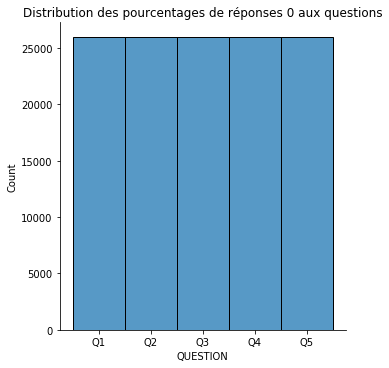

In [79]:
sns.displot(plot_data.QUESTION, )
plt.title("Distribution des pourcentages de réponses 0 aux questions")
plt.show()

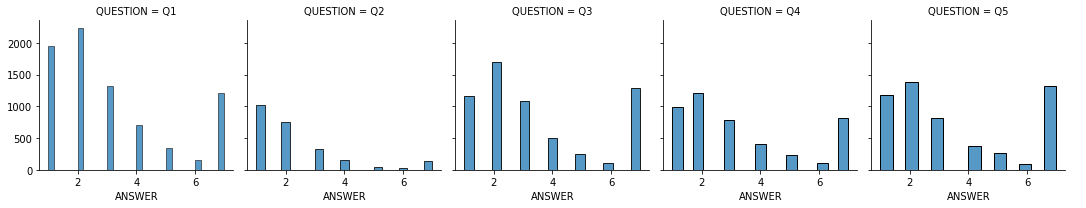

In [74]:
g = sns.FacetGrid(plot_data[plot_data.ANSWER != 0.0], col="QUESTION")
g.map(sns.histplot, "ANSWER")
g.add_legend()
plt.show()

Beaucoup de valeurs se rapprochent de 0. On remarque que très peu de ligne comportent une valeur NaN, nous décidons donc de les retirés du jeu de données afin de ne faussé aucun résultat

Au vue du nombre de réponses à 0, nous allons les retirer du jeu de données pour pouvoir mieux visualiser les informations sur l'évolution du CSI au cours de ces dernières années.

In [9]:
plot_data = plot_data[plot_data.CSI != 0.0]

## Analyse du CSI

Nous allons maintenant regarder la corrélation entre chaque questions. Ainsi que l'évolution du CSI durant ces dernières années, avec un découpage par région.

In [78]:
corr = raw_data[col["data"]].corr()
corr

,Q1,Q2,Q3,Q4,Q5
Q1,1.000000,0.269033,0.502409,0.437992,0.476009
Q2,0.269033,1.000000,0.296240,0.309871,0.302286
Q3,0.502409,0.296240,1.000000,0.624469,0.654127
Q4,0.437992,0.309871,0.624469,1.000000,0.592036
Q5,0.476009,0.302286,0.654127,0.592036,1.000000


In [36]:
#sns.heatmap(corr, vmax=1., center=0, square=True, linewidths=.5, cbar_kws={"shrink": 1})
# plt.savefig(img_path + "hist.svg")
#plt.show()

On peut remarquer que les questions 3, 4 et 5 semble être plus corrélées entre elles que les autres questions. Ce qui se traduit par le fait que ces questions représentes plus ou moins la même variance du CSI.

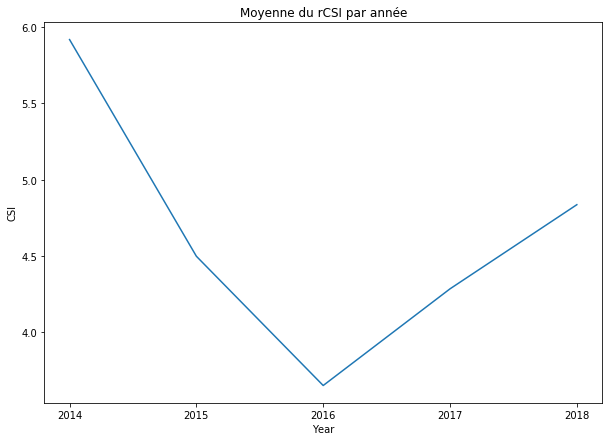

In [33]:
years, by_year = [], []
for year in raw_data.YEAR.unique():
    d = raw_data[raw_data.YEAR == year]
    by_year.append(d.CSI.mean())
    years.append(year)

plt.figure(figsize=(10,7))
sns.lineplot(x=years, y=by_year)
plt.title("Moyenne du rCSI par année")
plt.xlabel("Year")
plt.ylabel("CSI")
plt.xticks(np.arange(2014, 2019, step=1))
plt.show()

On remarque que le CSI à grandement diminué de 2014 jusqu'en 2016 puis est remonté jusqu'a 2018. 

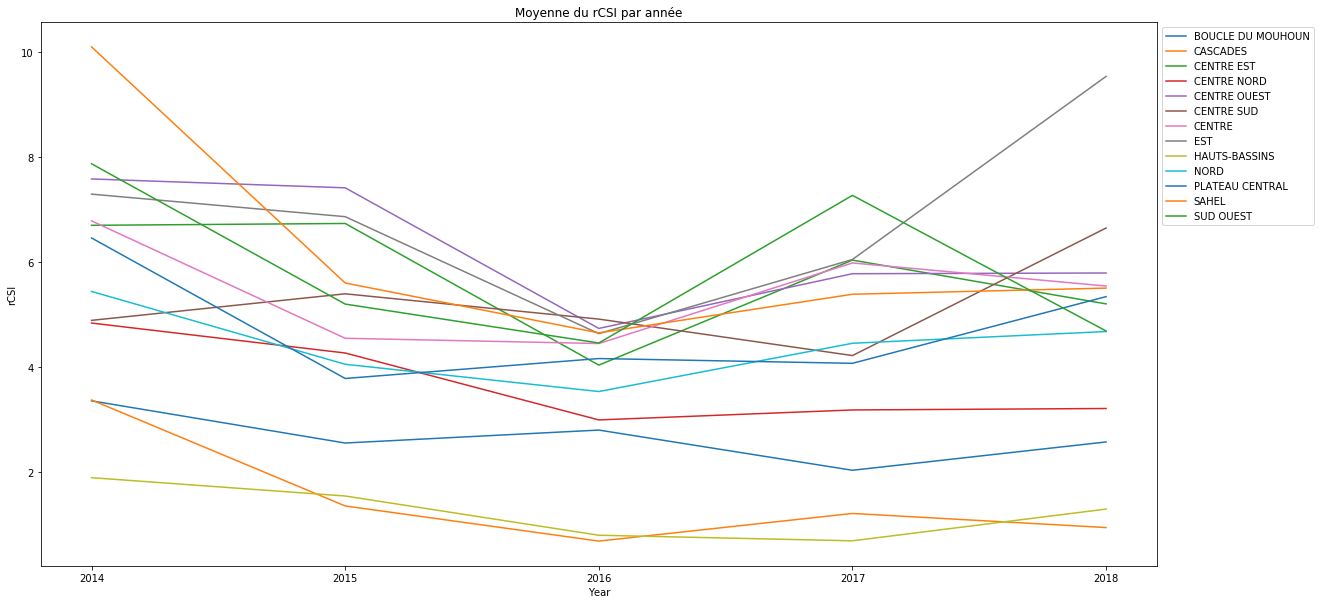

In [72]:
plt.figure(figsize=(20,10))

for reg in raw_data.REG.unique():
    years, by_year = [], []
    df = raw_data[raw_data.REG == reg]
    for year in df.YEAR.unique():
        d = df[df.YEAR == year]
        years.append(year)
        by_year.append(d.CSI.mean())

    sns.lineplot(x=years, y=by_year)

plt.legend(bbox_to_anchor=(1,1), labels=plot_data.REG.unique())
plt.title("Moyenne du rCSI par année")
plt.xlabel("Year")
plt.ylabel("rCSI")
plt.xticks(np.arange(2014, 2019, step=1))
plt.show()

In [35]:
#plt.figure(figsize=(15,7))
#sns.boxplot(x="YEAR", y="CSI", data=plot_data)
#plt.ylabel("rCSI")
#plt.show()